In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=45c52cb13106c5848394f0d72e63b712e967d5a07ccde03f68ff570a512d9468
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
import lime
import lime.lime_text

In [4]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Importing Pandas
import pandas as pd

# Define the URL to your dataset
url = "/content/drive/MyDrive/THE CODES/Amadi/fake_news.csv"  # Update this with your actual CSV file path

# Load the dataset
df = pd.read_csv(url)

# Display the first few rows to verify if it loaded correctly
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
# Sample a fraction of the data for faster hyperparameter tuning
df_sample = df.sample(frac=0.1, random_state=42)  # Use 10% of the data

In [10]:
# Data preprocessing
X_sample = df_sample['text'].fillna('')  # Handling any missing values in the text column
y_sample = df_sample['label']

# Splitting the data into training and testing sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

In [ ]:
# Generate word clouds for real and fake news
real_news = df[df['label'] == 0]['text'].fillna('').str.cat(sep=' ')
fake_news = df[df['label'] == 1]['text'].fillna('').str.cat(sep=' ')

In [ ]:
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_news)
wordcloud_fake = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(fake_news)


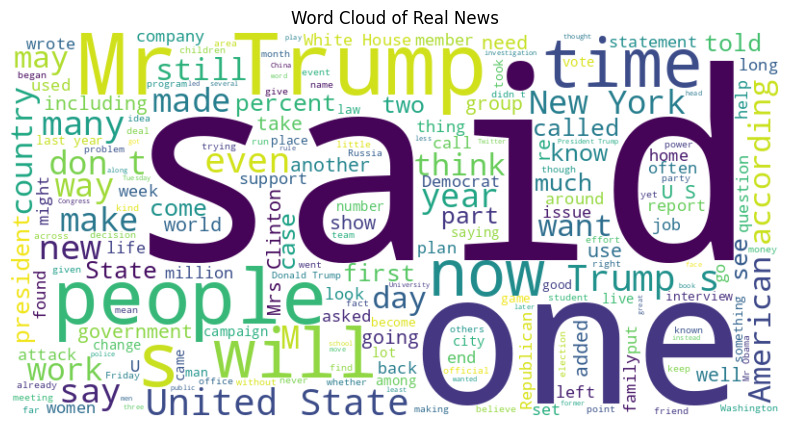

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Word Cloud of Real News')
plt.axis('off')
plt.show()

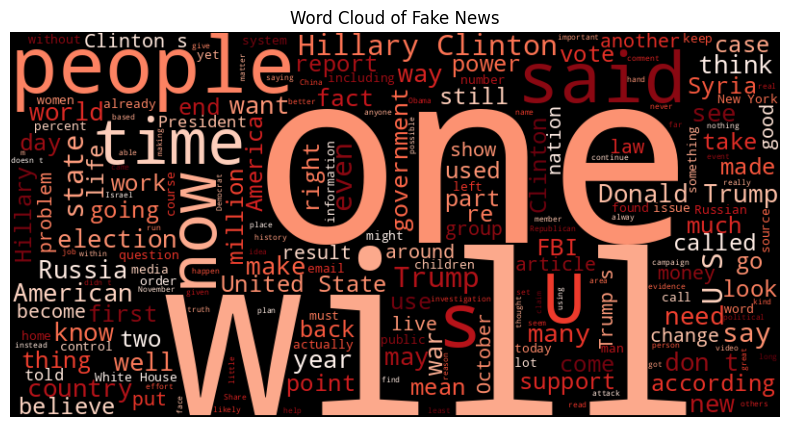

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Word Cloud of Fake News')
plt.axis('off')
plt.show()

In [11]:
# Vectorizing the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf_sample = tfidf_vectorizer.fit_transform(X_train_sample)
X_test_tfidf_sample = tfidf_vectorizer.transform(X_test_sample)


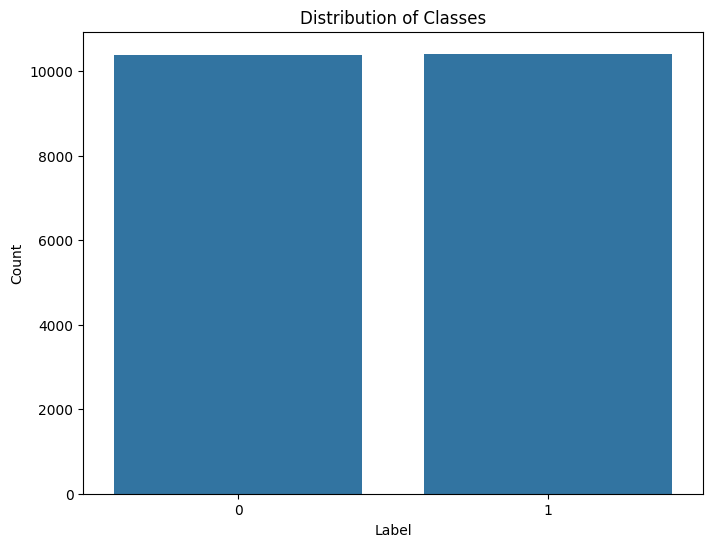

In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Classes')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [13]:
real_news = df[df['label'] == 0]['text'].fillna('').str.cat(sep=' ')
fake_news = df[df['label'] == 1]['text'].fillna('').str.cat(sep=' ')

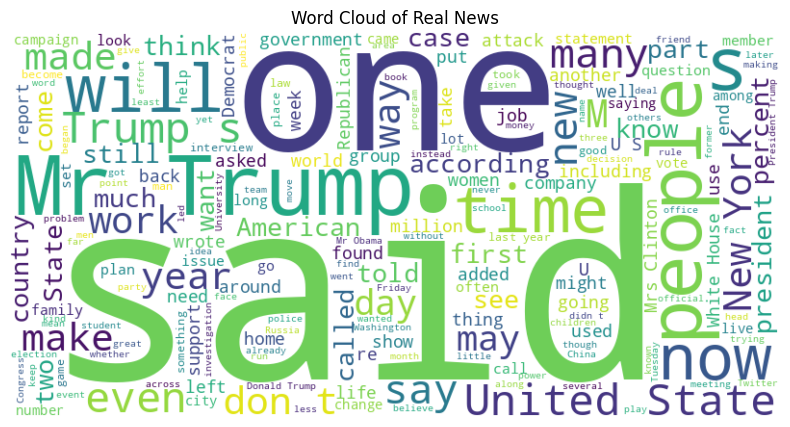

In [14]:
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_news)
wordcloud_fake = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(fake_news)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Word Cloud of Real News')
plt.axis('off')
plt.show()

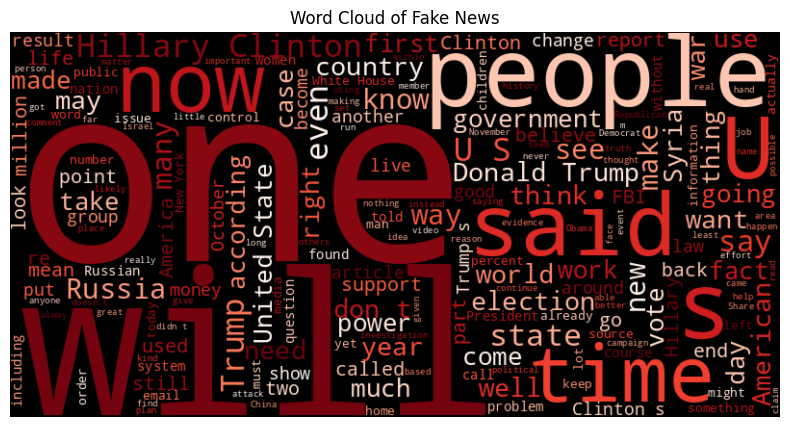

In [15]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Word Cloud of Fake News')
plt.axis('off')
plt.show()

In [16]:
# Logistic Regression
param_grid_logreg = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search_logreg = RandomizedSearchCV(LogisticRegression(), param_grid_logreg, cv=5, n_jobs=-1, verbose=2, n_iter=10)
grid_search_logreg.fit(X_train_tfidf_sample, y_train_sample)
best_logreg = grid_search_logreg.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [17]:
# SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
grid_search_svm = RandomizedSearchCV(SVC(probability=True), param_grid_svm, cv=5, n_jobs=-1, verbose=2, n_iter=5)  # Reduced n_iter to 5
grid_search_svm.fit(X_train_tfidf_sample, y_train_sample)
best_svm = grid_search_svm.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [19]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'criterion': ['gini', 'entropy']
}
grid_search_rf = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1, verbose=2, n_iter=10)
grid_search_rf.fit(X_train_tfidf_sample, y_train_sample)
best_rf = grid_search_rf.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [20]:
print("Best Parameters for Logistic Regression:", grid_search_logreg.best_params_)
print("Best Parameters for SVM:", grid_search_svm.best_params_)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

Best Parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100}
Best Parameters for SVM: {'kernel': 'rbf', 'C': 10}
Best Parameters for Random Forest: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy'}


In [21]:
# Predictions using the best models
y_pred_logreg = best_logreg.predict(X_test_tfidf_sample)
y_pred_svm = best_svm.predict(X_test_tfidf_sample)
y_pred_rf = best_rf.predict(X_test_tfidf_sample)

# Evaluation
accuracy_logreg = accuracy_score(y_test_sample, y_pred_logreg)
accuracy_svm = accuracy_score(y_test_sample, y_pred_svm)
accuracy_rf = accuracy_score(y_test_sample, y_pred_rf)

print("Accuracy for Logistic Regression:", accuracy_logreg)
print("Accuracy for SVM:", accuracy_svm)
print("Accuracy for Random Forest:", accuracy_rf)

Accuracy for Logistic Regression: 0.9302884615384616
Accuracy for SVM: 0.9326923076923077
Accuracy for Random Forest: 0.9086538461538461


In [22]:
conf_matrix_logreg = confusion_matrix(y_test_sample, y_pred_logreg)
conf_matrix_svm = confusion_matrix(y_test_sample, y_pred_svm)
conf_matrix_rf = confusion_matrix(y_test_sample, y_pred_rf)

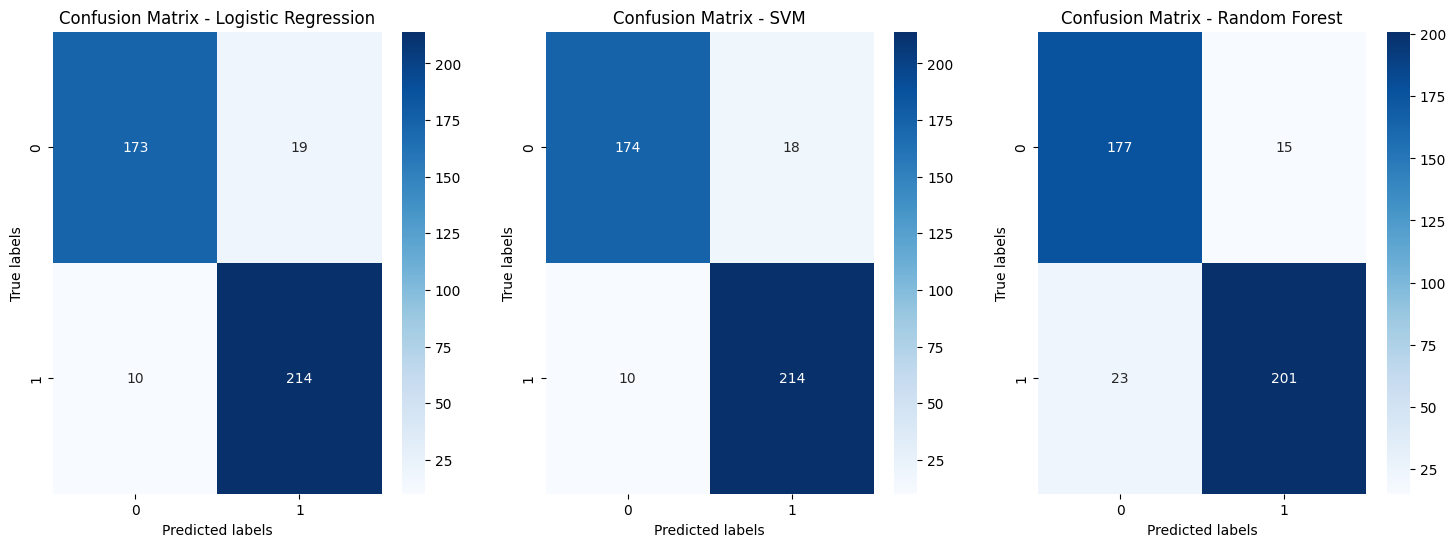

In [27]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Logistic Regression')


plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - SVM')

plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest')

plt.show()

In [28]:
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_sample, y_pred_logreg))

print("Classification Report for SVM:")
print(classification_report(y_test_sample, y_pred_svm))

print("Classification Report for Random Forest:")
print(classification_report(y_test_sample, y_pred_rf))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       192
           1       0.92      0.96      0.94       224

    accuracy                           0.93       416
   macro avg       0.93      0.93      0.93       416
weighted avg       0.93      0.93      0.93       416

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       192
           1       0.92      0.96      0.94       224

    accuracy                           0.93       416
   macro avg       0.93      0.93      0.93       416
weighted avg       0.93      0.93      0.93       416

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       192
           1       0.93      0.90      0.91       224

    accuracy                           0.91       416
   macro 

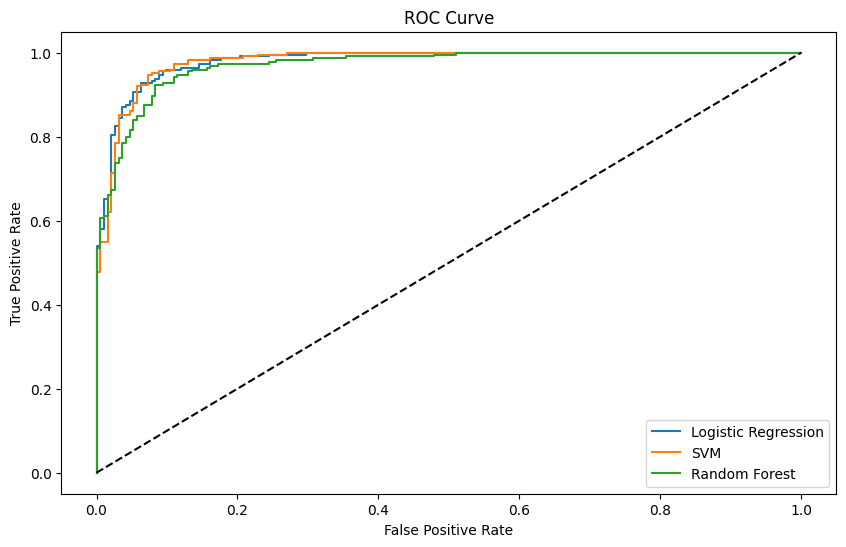

AUC for Logistic Regression: 0.98046875
AUC for SVM: 0.9793294270833334
AUC for Random Forest: 0.9703776041666666


In [29]:
y_prob_logreg = best_logreg.predict_proba(X_test_tfidf_sample)[:, 1]
y_prob_svm = best_svm.predict_proba(X_test_tfidf_sample)[:, 1]
y_prob_rf = best_rf.predict_proba(X_test_tfidf_sample)[:, 1]

fpr_logreg, tpr_logreg, _ = roc_curve(y_test_sample, y_prob_logreg)
fpr_svm, tpr_svm, _ = roc_curve(y_test_sample, y_prob_svm)
fpr_rf, tpr_rf, _ = roc_curve(y_test_sample, y_prob_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

auc_logreg = roc_auc_score(y_test_sample, y_prob_logreg)
auc_svm = roc_auc_score(y_test_sample, y_prob_svm)
auc_rf = roc_auc_score(y_test_sample, y_prob_rf)

print("AUC for Logistic Regression:", auc_logreg)
print("AUC for SVM:", auc_svm)
print("AUC for Random Forest:", auc_rf)

In [30]:
#Cross-Validation Scores
cv_scores_logreg = cross_val_score(best_logreg, X_train_tfidf_sample, y_train_sample, cv=5)
cv_scores_svm = cross_val_score(best_svm, X_train_tfidf_sample, y_train_sample, cv=5)
cv_scores_rf = cross_val_score(best_rf, X_train_tfidf_sample, y_train_sample, cv=5)

print("Cross-Validation Accuracy Scores for Logistic Regression:", cv_scores_logreg)
print("Mean Cross-Validation Accuracy for Logistic Regression:", cv_scores_logreg.mean())

print("Cross-Validation Accuracy Scores for SVM:", cv_scores_svm)
print("Mean Cross-Validation Accuracy for SVM:", cv_scores_svm.mean())

print("Cross-Validation Accuracy Scores for Random Forest:", cv_scores_rf)
print("Mean Cross-Validation Accuracy for Random Forest:", cv_scores_rf.mean())

Cross-Validation Accuracy Scores for Logistic Regression: [0.9009009  0.8978979  0.89189189 0.91591592 0.92168675]
Mean Cross-Validation Accuracy for Logistic Regression: 0.9056586707189117
Cross-Validation Accuracy Scores for SVM: [0.9009009  0.89489489 0.89189189 0.91291291 0.9186747 ]
Mean Cross-Validation Accuracy for SVM: 0.9038550598791563
Cross-Validation Accuracy Scores for Random Forest: [0.9039039  0.86486486 0.86186186 0.86486486 0.89156627]
Mean Cross-Validation Accuracy for Random Forest: 0.8774123521111473


Accuracy for Ensemble Model: 0.9375


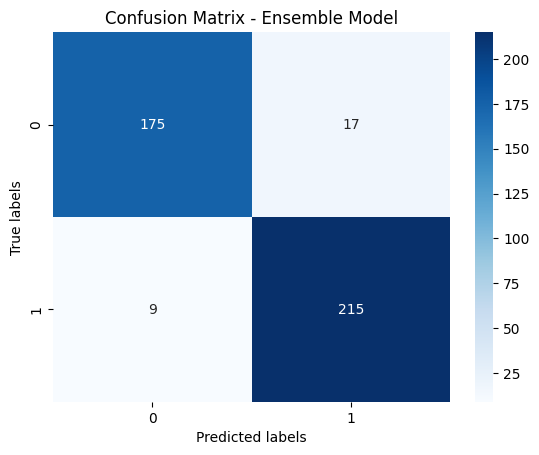

Classification Report for Ensemble Model:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       192
           1       0.93      0.96      0.94       224

    accuracy                           0.94       416
   macro avg       0.94      0.94      0.94       416
weighted avg       0.94      0.94      0.94       416



In [31]:
#Ensemble Model
ensemble_model = VotingClassifier(estimators=[
    ('logreg', best_logreg),
    ('svm', best_svm),
    ('rf', best_rf)
], voting='soft')

ensemble_model.fit(X_train_tfidf_sample, y_train_sample)
ensemble_y_pred = ensemble_model.predict(X_test_tfidf_sample)

# Evaluation for Ensemble Model
accuracy_ensemble = accuracy_score(y_test_sample, ensemble_y_pred)
print("Accuracy for Ensemble Model:", accuracy_ensemble)

# Confusion Matrix for Ensemble Model
conf_matrix_ensemble = confusion_matrix(y_test_sample, ensemble_y_pred)
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

print("Classification Report for Ensemble Model:")
print(classification_report(y_test_sample, ensemble_y_pred))

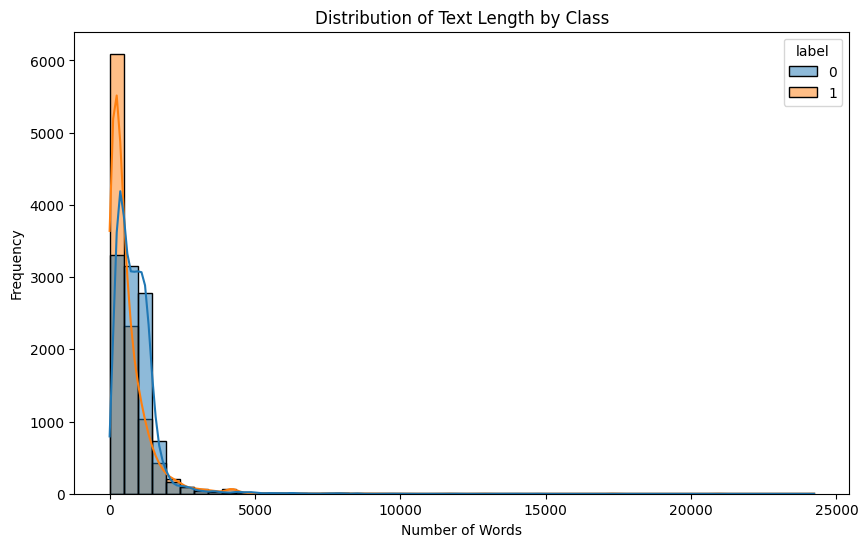

In [35]:
# Handle missing values in the 'text' column
df['text'] = df['text'].fillna('')

# Text length distribution
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Text Length by Class')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

<ipython-input-36-77a13d3cac2e>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=df_common_words, palette='viridis')


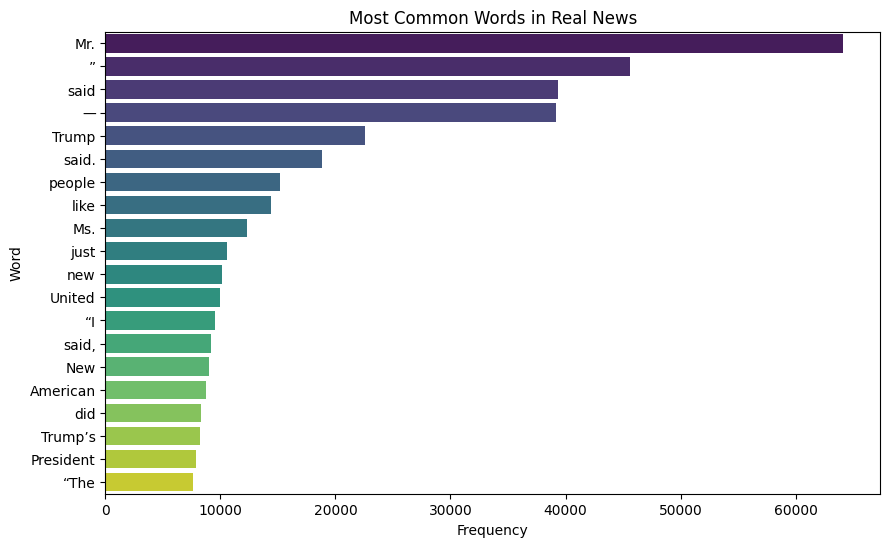

<ipython-input-36-77a13d3cac2e>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=df_common_words, palette='viridis')


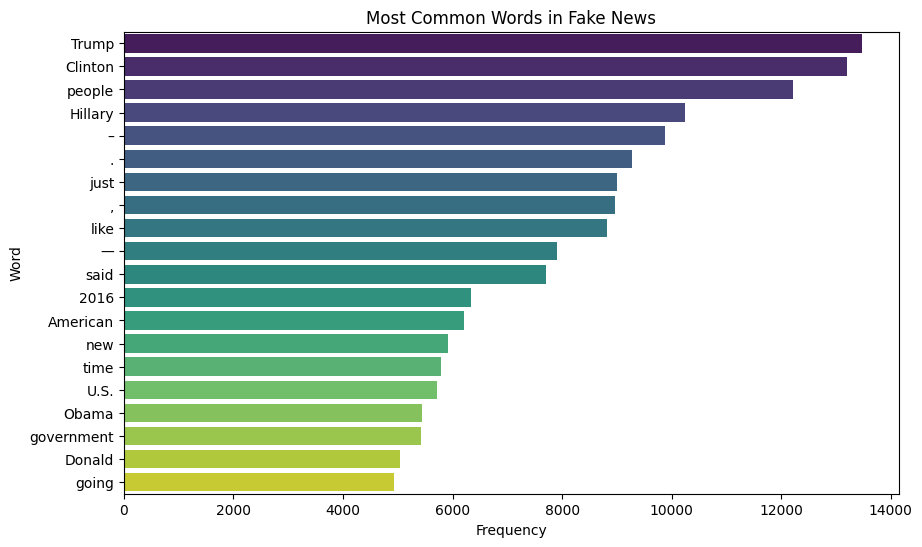

In [36]:
#Word Frequency Analysis
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Function to generate word frequency plot
def plot_word_frequencies(text_data, title):
    words = ' '.join(text_data).split()
    words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS]
    word_freq = Counter(words)
    common_words = word_freq.most_common(20)

    df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Word', data=df_common_words, palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

# Word frequency plot for real news
plot_word_frequencies(df[df['label'] == 0]['text'].fillna(''), 'Most Common Words in Real News')

# Word frequency plot for fake news
plot_word_frequencies(df[df['label'] == 1]['text'].fillna(''), 'Most Common Words in Fake News')

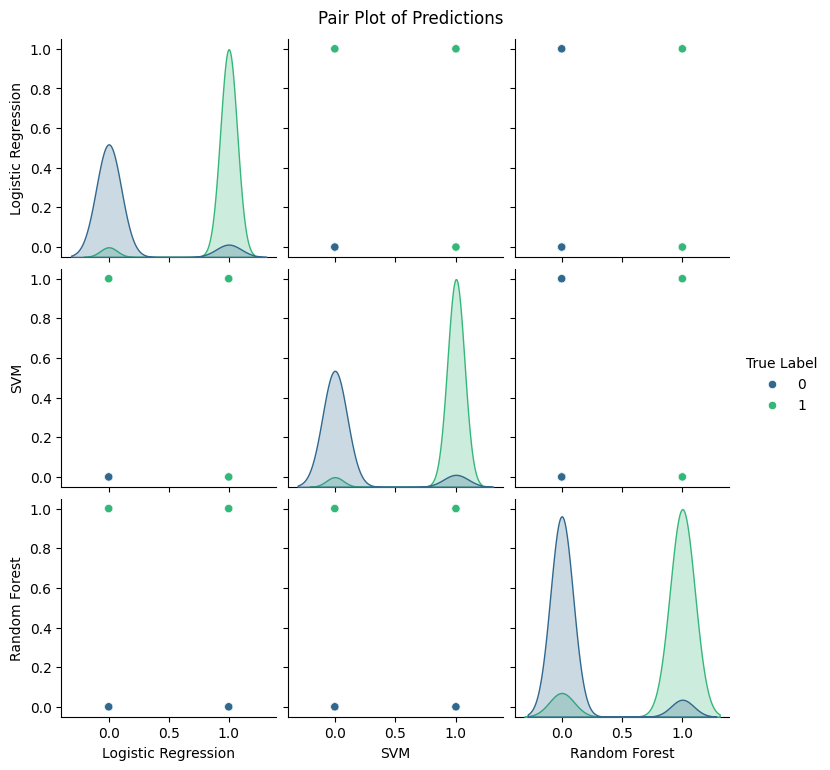

In [39]:
#Visualizing TF-IDF Features
# Create a dataframe with predictions
pred_df = pd.DataFrame({
    'Logistic Regression': y_pred_logreg,
    'SVM': y_pred_svm,
    'Random Forest': y_pred_rf,
    'True Label': y_test_sample
})

sns.pairplot(pred_df, hue='True Label', palette='viridis')
plt.suptitle('Pair Plot of Predictions', y=1.02)
plt.show()

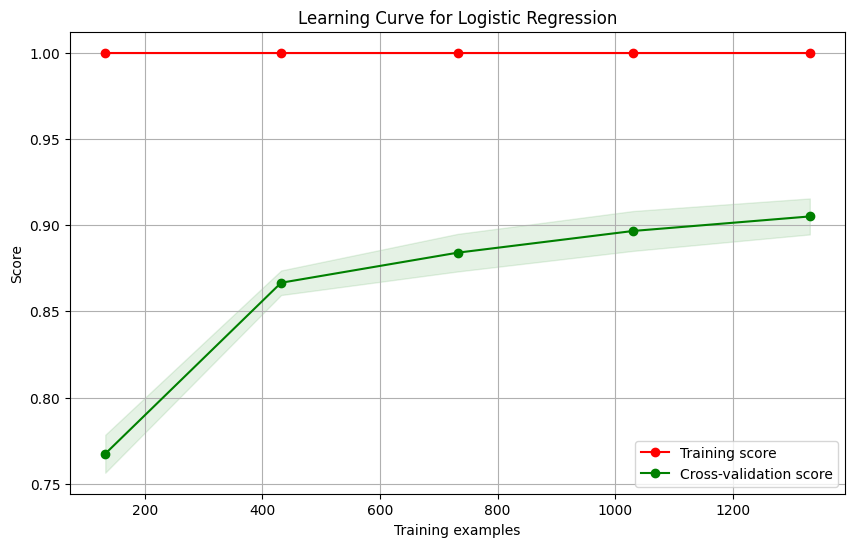

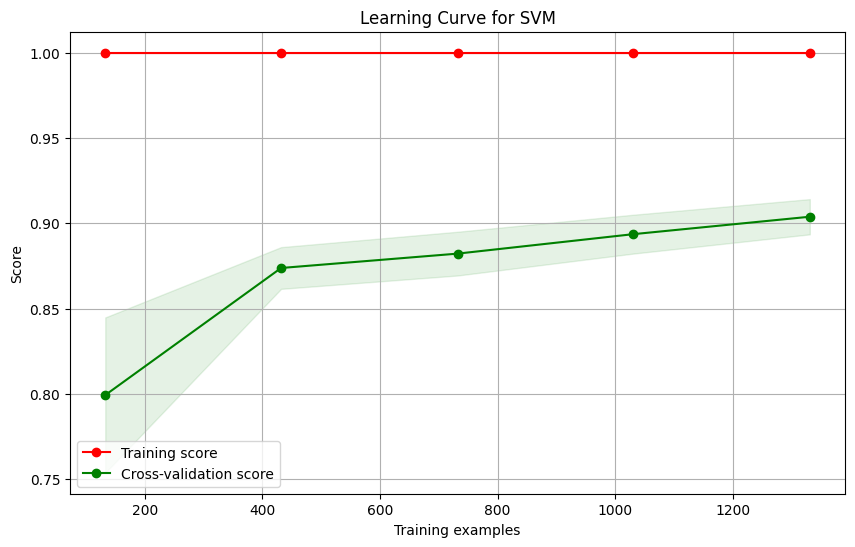

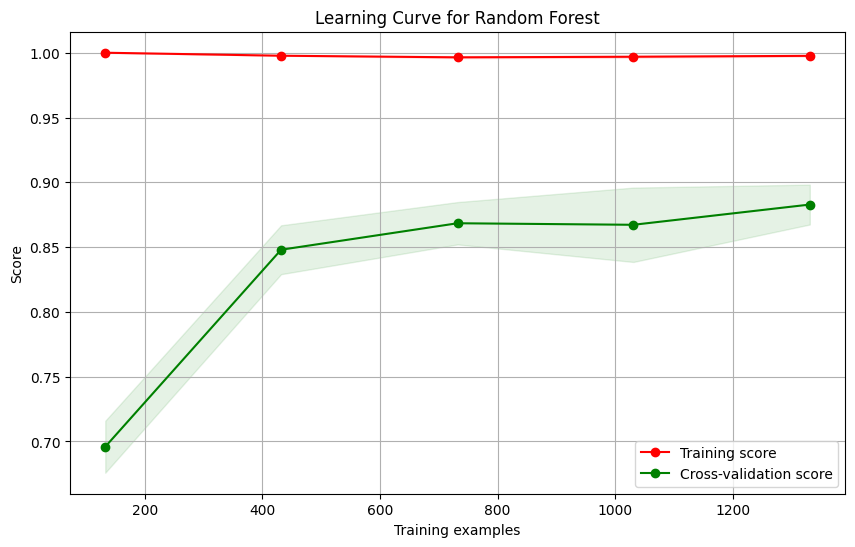

In [40]:
#Learning Curves
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, random_state=42)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.legend(loc='best')
    return plt

plot_learning_curve(best_logreg, 'Learning Curve for Logistic Regression', X_train_tfidf_sample, y_train_sample, cv=5, n_jobs=-1)
plt.show()

plot_learning_curve(best_svm, 'Learning Curve for SVM', X_train_tfidf_sample, y_train_sample, cv=5, n_jobs=-1)
plt.show()

plot_learning_curve(best_rf, 'Learning Curve for Random Forest', X_train_tfidf_sample, y_train_sample, cv=5, n_jobs=-1)
plt.show()

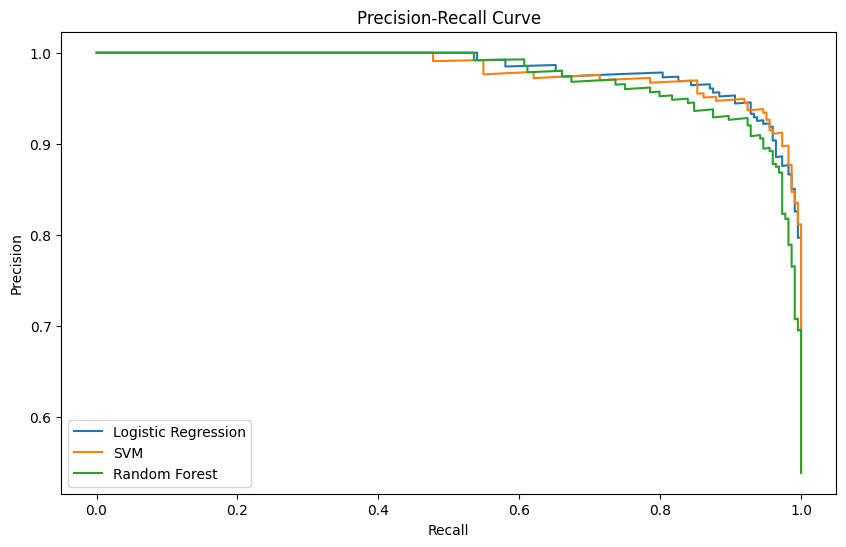

In [41]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall curve for Logistic Regression
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test_sample, y_prob_logreg)
precision_svm, recall_svm, _ = precision_recall_curve(y_test_sample, y_prob_svm)
precision_rf, recall_rf, _ = precision_recall_curve(y_test_sample, y_prob_rf)

plt.figure(figsize=(10, 6))
plt.plot(recall_logreg, precision_logreg, label='Logistic Regression')
plt.plot(recall_svm, precision_svm, label='SVM')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()